## RNN CLASSIFICATION
___
in 4 STEPS
 ___
1. Load data
2. Build model
3. Train model
4. Evaluate model
___

In [6]:
import numpy as np
import pandas as pd
import pickle
import os
import time

from sklearn.metrics import r2_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import Image
import tensorflow as tf

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, SimpleRNN, GRU
from keras.utils import np_utils, to_categorical, plot_model
from keras.callbacks import ModelCheckpoint, TensorBoard, \
    LearningRateScheduler
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.backend.tensorflow_backend import set_session
from keras.preprocessing.sequence import pad_sequences
from keras.datasets import mnist

# import wrapper_data as wd
# import lstm_wrapper as lw

# Many-to-one

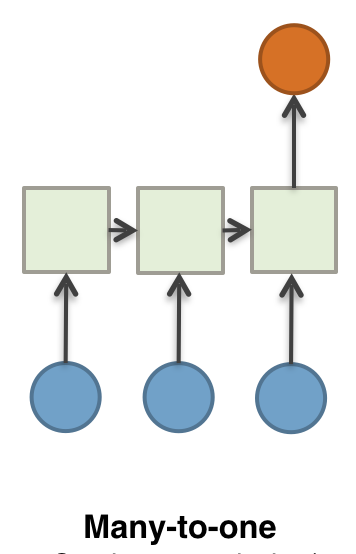

In [7]:
Image(filename="/src/keras/Gerome/01_main/95_keras_practice/many_to_one.png", height=200, width=200) 

* single vector output for every samples
* input_x.shape == (batch_size, timesteps, n_dims)
* target_y.shape == (batch_size, n_class)

## MOVING MNIST CLASSIFICATION
###### show samples from /src/keras/Gerome/01_main/95_keras_practice/digit_sample_new/

## 1. Load Data

In [8]:
(_, _), (_, y_data) = mnist.load_data()
data = np.load('/src/keras/Gerome/01_main/95_keras_practice/result_moving_random_mnist_25%_occlussion_X_test.npy')
data /= 255.0
data = data.reshape(-1,15, np.prod(data.shape[-2:]))
X_train, X_test, y_train, y_test = train_test_split(data, y_data, \
        test_size=2000, random_state=0, stratify=y_data)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000, 15, 1296), (8000, 10), (2000, 15, 1296), (2000, 10))

## 2. Build Model

In [10]:
# Model parameters
timesteps = X_train.shape[1]
n_dims = X_train.shape[2]
input_shape = (timesteps, n_dims)
hidden_units = 100
n_class = y_train.shape[-1]

In [11]:
model_classification = Sequential()
model_classification.add(LSTM(hidden_units, input_shape=input_shape))
model_classification.add(Dense(n_class, activation='softmax'))
model_classification.compile(loss='categorical_crossentropy', optimizer='RMSprop')

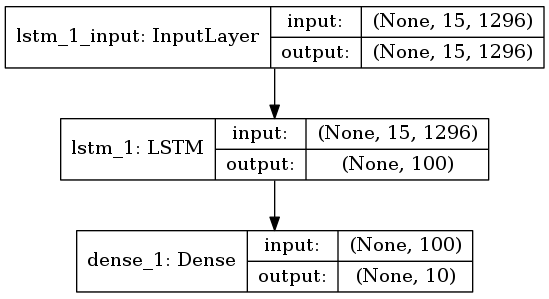

In [12]:
model_img_path = '/src/keras/Gerome/01_main/95_keras_practice/RNN_classification_model.png'
plot_model(model_classification, to_file=model_img_path, show_shapes=True)
Image(model_img_path)

In [13]:
# Check model outputs
model_classification.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               558800    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 559,810.0
Trainable params: 559,810
Non-trainable params: 0.0
_________________________________________________________________


## 3. Train Model

In [15]:
nb_epoch = 5
batch_size = 128
model_classification.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

Epoch 1/5
 640/8000 [=>............................] - ETA: 1s - loss: 2.2921 384/8000 [>.............................] - ETA: 1s - loss: 2.2999

/opt/conda/lib/python3.5/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


8000/8000 [==============================] - 1s - loss: 2.2950     1152/8000 [===>..........................] - ETA: 1s - loss: 2.2945

## 4. Evaluate Model

In [9]:
pred_c = model_classification.predict_classes(X_test)
confusion_matrix(np.argmax(y_test, axis=1), pred_c)

1984/2000 [============================>.] - ETA: 0s 256/2000 [==>...........................] - ETA: 0s

array([[  0,   1,  26,   0,  11,   5,   0,  16,   2, 135],
       [  0,   2,   3,   0,  24,   3,   0,  13,   1, 181],
       [  0,   0,  15,   0,  19,   5,   0,  20,   0, 147],
       [  0,   0,  15,   0,  13,   2,   0,  18,   0, 154],
       [  0,   0,   6,   0,  13,   3,   0,  18,   0, 156],
       [  0,   0,  19,   0,   6,   6,   0,  11,   0, 136],
       [  0,   0,  14,   0,  18,   3,   0,  12,   0, 145],
       [  0,   1,   6,   0,  20,   6,   0,   9,   0, 164],
       [  0,   1,  16,   0,  13,   5,   0,  15,   0, 145],
       [  0,   0,  14,   1,  13,   7,   0,  22,   0, 145]])

In [10]:
accuracy_score(np.argmax(y_test, axis=1), pred_c)

0.095000000000000001

# Many-to-many

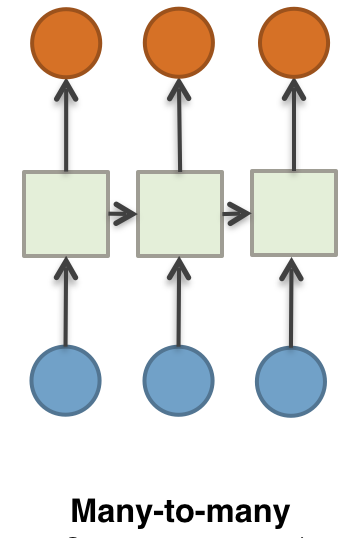

In [24]:
Image(filename="/src/keras/Gerome/01_main/95_keras_practice/many_to_many.png", height=200, width=200) 

* single vector output for every timestep
* input_x.shape == (batch_size, timesteps, n_dims)
* target_y.shape == (batch_size, timesteps, n_class)

## MOVING MNIST with CHANGING CLASS LABELS
###### show samples from /src/keras/Gerome/01_main/95_keras_practice/moving_mnist_changing_class

## 1. Load Data

In [18]:
data_2 = np.load('/src/keras/Gerome/01_main/95_keras_practice/moving_mnist_changing_class/moving_mnist_changing_class.npy')
# 1 hot encoding class labels
labels_2 = np.load('/src/keras/Gerome/01_main/95_keras_practice/moving_mnist_changing_class/moving_mnist_changing_class_1hot_y.npy')
# standard class labels
y_labels_2 = np.load('/src/keras/Gerome/01_main/95_keras_practice/moving_mnist_changing_class/moving_mnist_changing_class_labels_y.npy')

data_2 /= 255.0
data_2 = data_2.reshape(-1, 20, np.prod(data_2.shape[-2:]))
X_train, X_test, y_train, y_test = train_test_split(data_2, labels_2, \
        test_size=2000, random_state=0, stratify=y_labels_2)

In [19]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000, 20, 1296), (8000, 20, 10), (2000, 20, 1296), (2000, 20, 10))

## 2. Build Model

In [20]:
# Model parameters
n_class = y_train.shape[-1]
# Model parameters
timesteps = X_train.shape[1]
n_dims = X_train.shape[2]
input_shape = (timesteps, n_dims)
hidden_units = 100
n_class = y_train.shape[-1]

In [21]:
model_c_many = Sequential()
model_c_many.add(LSTM(hidden_units,
               input_shape=input_shape,
                             return_sequences=True))
model_c_many.add(TimeDistributed(Dense(n_class, activation='softmax')))
model_c_many.compile(loss='categorical_crossentropy', optimizer='RMSprop') 

In [25]:
model_c_many.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20, 100)           558800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 10)            1010      
Total params: 559,810.0
Trainable params: 559,810
Non-trainable params: 0.0
_________________________________________________________________


## 3. Train Model

In [28]:
nb_epoch = 5
batch_size = 128
model_c_many.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

/opt/conda/lib/python3.5/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/5
8000/8000 [==============================] - 2s - loss: 2.3216     3 384/8000 [>.............................] - ETA: 5s - loss: 2.5751 

## 4. Evaluate Model

In [43]:
# Predicted labels
pred_c = model_c_many.predict_classes(X_test)

1824/2000 [==========================>...] - ETA: 0s 192/2000 [=>............................] - ETA: 0s

In [48]:
# True labels
true_y = np.argmax(y_test, axis=2)

In [49]:
# Evaluate accuracy every timestep
overall_acc = []
for i in range(pred_c.shape[-1]):
    cur_pred = pred_c[:, i]
    cur_true = true_y[:,i]
    cur_score = accuracy_score(cur_true, cur_pred)
    overall_acc.append(cur_score)

In [51]:
# Mean of
np.mean(overall_acc)

0.144675